# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

pd.set_option('max_colwidth',100)

In [3]:
PATH = "/data/msnow/kaggle/titanic/"
!ls {PATH}

predict_survive.csv  test.csv  tmp  train.csv


shuf

%prun

# Data Exploration

## Explore the dataset before loading all the rows

In [4]:
train_raw = pd.read_csv(f'{PATH}train.csv', nrows = 10**3)

In [5]:
train_raw.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
train_raw.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
train_raw.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [8]:
train_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Load the full dataset

In [9]:
train_raw = pd.read_csv(f'{PATH}train.csv',dtype={'PassengerId':np.int16,'Survived':np.int8, 'Pclass':np.int8, 'Age':np.float32, 'SibSp':np.int8, 'Parch':np.int8,'Fare':np.float32})

In [10]:
train_raw.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693428  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329224

In [11]:
train_raw.dtypes

PassengerId      int16
Survived          int8
Pclass            int8
Name            object
Sex             object
Age            float32
SibSp             int8
Parch             int8
Ticket          object
Fare           float32
Cabin           object
Embarked        object
dtype: object

## Feature Engineering

Split Name into first, last, husband and title

In [12]:
def name_split(train_raw):
    train_feat = train_raw.copy()
    Name_splt = train_feat.Name.str.split(',',expand=True)
    train_feat['Last_Name'] = Name_splt[0]
    Name_splt = Name_splt[1].str.split('.',expand=True)
    train_feat['Title'] = Name_splt[0]
    Name_splt = Name_splt[1].str.split('(',expand=True)
    train_feat['First_Name'] = Name_splt[0]
    train_feat['Husband'] = Name_splt[0]
    Name_splt = Name_splt[1].str.extract('([a-zA-Z-\s]*)',expand=True )
    train_feat['Wife'] = Name_splt
    train_feat['Maiden_Name'] = Name_splt[0].str.extract('\s([a-zA-Z-]+)$',expand=True )
    train_feat.loc[train_feat.Wife.notnull(),'First_Name'] = train_feat.loc[train_feat.Wife.notnull(),'Wife']
    train_feat.loc[train_feat.Wife.isnull(),'Husband'] = np.NAN
    train_feat.drop(['Name','Wife'],axis=1,inplace=True)
    return family_names(train_feat)

In [13]:
def family_names(train_feat):
    train_feat['Family_Name'] = np.NAN
    MN_unq = train_feat.Maiden_Name[train_feat.Maiden_Name.notnull()].unique()
    LN_unq = train_feat.Last_Name[train_feat.Last_Name.notnull()].unique()
    combi_names = []
    combi_names_set = {}
    for i,v in enumerate(MN_unq):
        tst = [v]
        combi_names.append([])
        while len(tst) > 0:
            combi_names[-1].append(tst.pop())
            tst += train_feat.loc[train_feat.Maiden_Name==combi_names[-1][-1],'Last_Name'].tolist()
    for i in LN_unq:
        combi_names_set[i] = [i]
        for j in combi_names:
            if i in j:
                combi_names_set[i] += j 
        combi_names_set[i] = list(set(combi_names_set[i]))
        train_feat.loc[train_feat.Last_Name==i,'Family_Name'] = '-'.join(combi_names_set[i])
    train_feat.drop(['Maiden_Name','First_Name','Last_Name','Husband'],axis=1,inplace=True)
    return train_feat

In [14]:
def name_related(train_feat):
    train_feat['Relatives'] = 0
    train_grp = train_feat.groupby(['Family_Name','Pclass'])
    grp_kys = list(train_grp.groups.keys())
    grp_sze = list(train_grp.size())
    for v in range(len(grp_kys)):
        train_feat.loc[train_grp.get_group(grp_kys[v]).index,'Relatives'] = grp_sze[v]-1
    return train_feat

In [15]:
train_feat = name_split(train_raw)
train_feat.head(10)

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   
5            6         0       3    male   NaN      0      0   
6            7         0       1    male  54.0      0      0   
7            8         0       3    male   2.0      3      1   
8            9         1       3  female  27.0      0      2   
9           10         1       2  female  14.0      1      0   

             Ticket       Fare Cabin Embarked    Title            Family_Name  
0         A/5 21171   7.250000   NaN        S       Mr                 Braund  
1          PC 17599  71.283302   C85        C      Mrs  Morris-Cumings-Thayer  
2  STON/O2. 3101282   7.925000   NaN        S     Miss              Heikkinen  
3            113803  53.099998  C123        S      Mrs          Peel-Futrelle  
4            373450   8.050000   NaN        S       Mr                  Allen  
5            330877   8.458300   NaN        Q       Mr                  Moran  
6             17463  51.862499   E46        S       Mr               McCarthy  
7            349909  21.075001   NaN        S   Master       Berglund-Palsson  
8            347742  11.133300   NaN        S      Mrs           Johnson-Berg  
9            237736  30.070801   NaN        C      Mrs           Nasser-Achem

Determine the number of relatives on board based on last name and passenger class

In [16]:
# train_feat['Relatives'] = 0
# train_grp = train_feat.groupby(['Last_Name','Pclass'])
# grp_kys = list(train_grp.groups.keys())
# grp_sze = list(train_grp.size())
# # train_grp.get_group(grp_kys[6])
# for v in range(len(grp_kys)):
#     train_feat.loc[train_grp.get_group(grp_kys[v]).index,'Relatives'] = grp_sze[v]-1
train_feat = name_related(train_feat)
train_feat.head(10)

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   
5            6         0       3    male   NaN      0      0   
6            7         0       1    male  54.0      0      0   
7            8         0       3    male   2.0      3      1   
8            9         1       3  female  27.0      0      2   
9           10         1       2  female  14.0      1      0   

             Ticket       Fare Cabin Embarked    Title            Family_Name  \
0         A/5 21171   7.250000   NaN        S       Mr                 Braund   
1          PC 17599  71.283302   C85        C      Mrs  Morris-Cumings-Thayer   
2  STON/O2. 3101282   7.925000   NaN        S     Miss              Heikkinen   
3            113803  53.099998  C123        S      Mrs          Peel-Futrelle   
4            373450   8.050000   NaN        S       Mr                  Allen   
5            330877   8.458300   NaN        Q       Mr                  Moran   
6             17463  51.862499   E46        S       Mr               McCarthy   
7            349909  21.075001   NaN        S   Master       Berglund-Palsson   
8            347742  11.133300   NaN        S      Mrs           Johnson-Berg   
9            237736  30.070801   NaN        C      Mrs           Nasser-Achem   

   Relatives  
0          1  
1          3  
2          0  
3          1  
4          0  
5          2  
6          0  
7          4  
8          5  
9          1

Convert less oftenly used titles to more comonly used ones for the purposes of determining median age based on title

In [17]:
train_feat.Title.unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme', ' Ms', ' Major', ' Lady', ' Sir',
       ' Mlle', ' Col', ' Capt', ' the Countess', ' Jonkheer'], dtype=object)

In [18]:
def title_age_median(train_feat):
    train_feat['Title_Age'] = train_feat.Title
    train_feat.loc[train_feat.Title == ' Dr','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Don','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Rev','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Major','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Sir','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Col','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Capt','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Jonkheer','Title_Age'] = ' Mr'
    train_feat.loc[train_feat.Title==' Mme','Title_Age'] = ' Mrs'
    train_feat.loc[train_feat.Title==' Lady','Title_Age'] = ' Mrs'
    train_feat.loc[train_feat.Title==' the Countess','Title_Age'] = ' Mrs'
    train_feat.loc[train_feat.Title==' Mlle','Title_Age'] = ' Miss'
    train_feat.loc[train_feat.Title==' Ms','Title_Age'] = ' Miss'
    train_feat['Age_na'] = train_feat.Age.isnull()
    for i in train_feat.Title_Age.unique():
        loc_true = (train_feat.Title_Age == i) & train_feat.Age.isnull()
        train_feat.loc[loc_true,'Age'] = train_feat.loc[train_feat.Title_Age == i,'Age'].median()
    return train_feat
# train_feat.Title_Age.unique()

In [19]:
train_feat = title_age_median(train_feat)

In [20]:
train_feat.head()

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket       Fare Cabin Embarked  Title            Family_Name  \
0         A/5 21171   7.250000   NaN        S     Mr                 Braund   
1          PC 17599  71.283302   C85        C    Mrs  Morris-Cumings-Thayer   
2  STON/O2. 3101282   7.925000   NaN        S   Miss              Heikkinen   
3            113803  53.099998  C123        S    Mrs          Peel-Futrelle   
4            373450   8.050000   NaN        S     Mr                  Allen   

   Relatives Title_Age  Age_na  
0          1        Mr   False  
1          3       Mrs   False  
2          0      Miss   False  
3          1       Mrs   False  
4          0        Mr   False

## Convert strings into categorical variables

train_cats converts any string rows to categorical type

In [21]:
train_cats(train_feat)

In [22]:
train_feat.dtypes

PassengerId       int16
Survived           int8
Pclass             int8
Sex            category
Age             float32
SibSp              int8
Parch              int8
Ticket         category
Fare            float32
Cabin          category
Embarked       category
Title          category
Family_Name    category
Relatives         int64
Title_Age      category
Age_na             bool
dtype: object

In [23]:
train_feat.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [24]:
train_feat.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

To change the category order (for ordinal categorical variables use `set_categories`

In [25]:
train_feat.Sex.cat.set_categories(['male','female'], ordered=True, inplace=True)

In [26]:
train_feat.Sex.cat.codes.head()

0    0
1    1
2    1
3    1
4    0
dtype: int8

In [27]:
train_feat.Cabin.cat.categories

Index(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31', 'A32',
       ...
       'E8', 'F E69', 'F G63', 'F G73', 'F2', 'F33', 'F38', 'F4', 'G6', 'T'],
      dtype='object', length=147)

In [28]:
train_feat.Cabin.cat.codes.head()

0    -1
1    81
2    -1
3    55
4    -1
dtype: int16

In [29]:
train_feat.isnull().sum()/len(train_raw)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
Title          0.000000
Family_Name    0.000000
Relatives      0.000000
Title_Age      0.000000
Age_na         0.000000
dtype: float64

Drop unhelpful categories (i.e., categories which will not translate over to the test set)

In [30]:
train_feat.drop(['Cabin','Family_Name','Ticket'],axis=1,inplace=True)

In [31]:
train_feat['Fare_na'] = train_feat.Fare.isnull()

In [32]:
train_feat.to_feather(f'{PATH}tmp/train_feat')

`proc_df` replaces categories with numeric codes, handles missing continuous values and splits the dependent variable in a separate variable

In [33]:
df, y, nas = proc_df(train_feat, 'Survived')

In [34]:
[(n,len(df[n].unique())) for n,c in df.items()]    

[('PassengerId', 891),
 ('Pclass', 3),
 ('Sex', 2),
 ('Age', 89),
 ('SibSp', 7),
 ('Parch', 7),
 ('Fare', 248),
 ('Embarked', 4),
 ('Title', 17),
 ('Relatives', 8),
 ('Title_Age', 4),
 ('Age_na', 2),
 ('Fare_na', 1)]

## Visualization

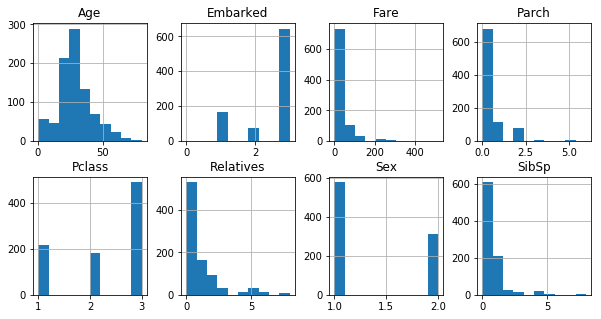

In [35]:
# _= df.hist... supresses the array output which otherwise would have been printed
_ = df.hist(column = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Relatives'],figsize=(10,5),layout=(2,4))

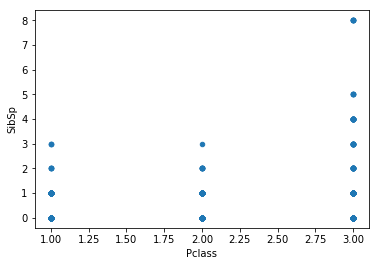

In [36]:
_=df.plot('Pclass','SibSp',figsize=(6,4),kind='scatter')

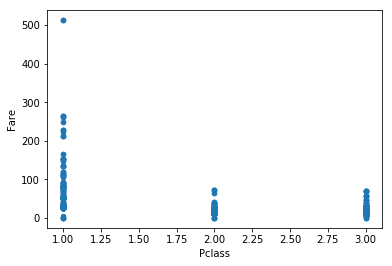

In [37]:
_=df.plot('Pclass','Fare',figsize=(6,4),kind='scatter')

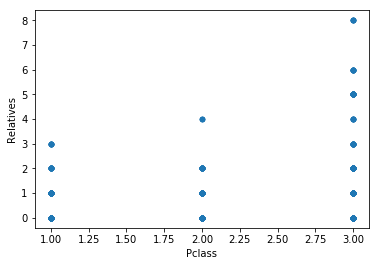

In [38]:
_=df.plot('Pclass','Relatives',figsize=(6,4),kind='scatter')

# Random Forest

## Load the test set

In [39]:
test_raw = pd.read_csv(f'{PATH}test.csv',dtype={'PassengerId':np.int16, 'Pclass':np.int8, 'Age':np.float32, 'SibSp':np.int8, 'Parch':np.int8,'Fare':np.float32})
print(test_raw.shape)
test_raw.head()

(418, 11)


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [40]:
test_feat = name_split(test_raw)
test_feat = name_related(test_feat)
test_feat = title_age_median(test_feat)
test_feat.head(10)

PassengerId  Pclass     Sex   Age  SibSp  Parch     Ticket     Fare Cabin  \
0          892       3    male  34.5      0      0     330911   7.8292   NaN   
1          893       3  female  47.0      1      0     363272   7.0000   NaN   
2          894       2    male  62.0      0      0     240276   9.6875   NaN   
3          895       3    male  27.0      0      0     315154   8.6625   NaN   
4          896       3  female  22.0      1      1    3101298  12.2875   NaN   
5          897       3    male  14.0      0      0       7538   9.2250   NaN   
6          898       3  female  30.0      0      0     330972   7.6292   NaN   
7          899       2    male  26.0      1      1     248738  29.0000   NaN   
8          900       3  female  18.0      0      0       2657   7.2292   NaN   
9          901       3    male  21.0      2      0  A/4 48871  24.1500   NaN   

  Embarked  Title          Family_Name  Relatives Title_Age  Age_na  
0        Q     Mr                Kelly          0        Mr   False  
1        S    Mrs         Needs-Wilkes          0       Mrs   False  
2        Q     Mr                Myles          0        Mr   False  
3        S     Mr                 Wirz          0        Mr   False  
4        S    Mrs   Hirvonen-Lindqvist          0       Mrs   False  
5        S     Mr             Svensson          0        Mr   False  
6        Q   Miss             Connolly          0      Miss   False  
7        S     Mr             Caldwell          0        Mr   False  
8        C    Mrs         Easu-Abrahim          0       Mrs   False  
9        S     Mr  Holmes-Davies-White          2        Mr   False

In [41]:
test_feat.drop(['Cabin','Family_Name','Ticket'],axis=1,inplace=True)
test_feat.isnull().sum()/len(test_feat)

PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Fare           0.002392
Embarked       0.000000
Title          0.000000
Relatives      0.000000
Title_Age      0.000000
Age_na         0.000000
dtype: float64

In [42]:
train_cats(test_feat)

In [43]:
for i in test_feat.columns[test_feat.dtypes=='category']:
    test_feat[i].cat.set_categories(train_feat[i].cat.categories.tolist(), ordered=True, inplace=True)

In [44]:
test_feat['y_fld'] = 0
df_test, _, _ = proc_df(test_feat, y_fld='y_fld')

In [45]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = round(len(test_raw)*0.1)  # same as Kaggle's test set size
n_trn = len(df)-n_valid
# raw_train, raw_valid = split_vals(train_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((849, 13), (849,), (42, 13))

## Base Random Forest Model

In [46]:
def acc(m,x,y): return sum(m.predict(x).round() == y)/len(x)

def print_score(m):
    print(f'Train accuracy: {acc(m,X_train,y_train)}')
    print(f'Valid accuracy: {acc(m,X_valid,y_valid)}')
    print(f'Train r^2: {m.score(X_train,y_train)}')
    print(f'Valid r^2: {m.score(X_valid,y_valid)}')
    if hasattr(m, 'oob_score_'): 
        print(f'oob r^2: {m.oob_score_}')

In [47]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: user 68.3 ms, sys: 15.6 ms, total: 83.9 ms
Wall time: 125 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
print_score(m)

Train accuracy: 0.9764428739693758
Valid accuracy: 0.8333333333333334
Train r^2: 0.8906220786846741
Valid r^2: 0.5009411764705882


## Single Tree

In [49]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.8327444051825678
Valid accuracy: 0.8571428571428571
Train r^2: 0.48662478110644125
Valid r^2: 0.6343523161004716


In [53]:
((y_train.mean() - y_train)**2).mean()

0.23626493303977103

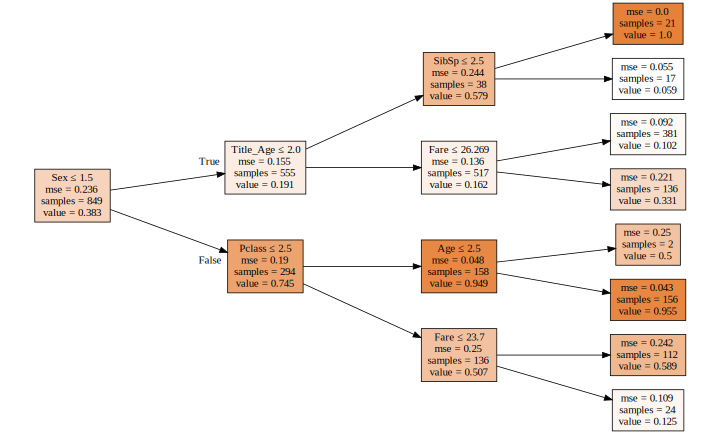

In [51]:
draw_tree(m.estimators_[0], X_train, precision=3)

In [256]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 1.0
Valid accuracy: 0.8809523809523809
Train r^2: 1.0
Valid r^2: 0.5058823529411764


## Bagging

### Intro to Bagging

Starting with the basic model

In [257]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.983510011778563
Valid accuracy: 0.8571428571428571
Train r^2: 0.885686611861421
Valid r^2: 0.5898823529411764


Grab the predictions for each individual tree

In [258]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 1.0, 1)

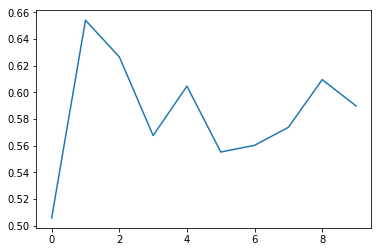

In [279]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);
plt.show()

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [260]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.9705535924617197
Valid accuracy: 0.8809523809523809
Train r^2: 0.8830443922489724
Valid r^2: 0.6709176470588235


In [261]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.9941107184923439
Valid accuracy: 0.8809523809523809
Train r^2: 0.9101769964768056
Valid r^2: 0.598035294117647


In [262]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.9941107184923439
Valid accuracy: 0.9047619047619048
Train r^2: 0.9119156268349969
Valid r^2: 0.6333647058823529


In [267]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 1.0
Valid accuracy: 0.9285714285714286
Train r^2: 0.9155728264459777
Valid r^2: 0.6650036764705882


### Out-of-bag (OOB) score

In [272]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 1.0
Valid accuracy: 0.9047619047619048
Train r^2: 0.91594052495596
Valid r^2: 0.6384047058823529
oob r^2: 0.4058122835791892


In [273]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
m.fit(df, y)
print_score(m)

Train accuracy: 1.0
Valid accuracy: 1.0
Train r^2: 0.9190030070463886
Valid r^2: 0.9404884705882353
oob r^2: 0.4200151908835922


## Reducing over-fitting

### Subsampling

In [171]:
set_rf_samples(200)

In [172]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.8885057471264368
Valid accuracy: 1.0
Train r^2: 0.6273890361277722
Valid r^2: 0.6957142857142856
oob r^2: 0.41184713274811013


In [173]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.8908045977011494
Valid accuracy: 1.0
Train r^2: 0.6466421397684474
Valid r^2: 0.6995982142857142
oob r^2: 0.43642063175010637


### Tree building parameters

In [174]:
reset_rf_samples()

In [175]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 1.0
Valid accuracy: 1.0
Train r^2: 0.9241920421258195
Valid r^2: 0.7559821428571428
oob r^2: 0.4280033654139529


In [176]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

Train accuracy: 0.9448275862068966
Valid accuracy: 1.0
Train r^2: 0.7949463598622611
Valid r^2: 0.7463032525647897
oob r^2: 0.44166198517068145


In [290]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df, y)
print_score(m)

Train accuracy: 0.9140164899882215
Valid accuracy: 0.9761904761904762
Train r^2: 0.7341984007061385
Valid r^2: 0.819145162377572
oob r^2: 0.45354467791259934


In [295]:
Tst_survive = m.predict(df_test).round()

In [298]:
predict_survive = pd.DataFrame(data = {'PassengerId':df_test.PassengerId,'Survived':Tst_survive.astype(int)})
predict_survive.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [299]:
predict_survive.to_csv(f'{PATH}predict_survive.csv',index=False)